In [ ]:
import sys
sys.path.append('../MOD550-task2')
from MOD550-task1.task1_methods import DataAquisition 


data = DataModel(rows_from_data=1500000).data # Load only 1.5 million rows for faster computation. Not all IDs have ratings, therefore some are deleted.



SyntaxError: invalid syntax (1302027215.py, line 1)

Creating a new column that is 1 if the rating is 7 or over, and 0 if not. This is to create a parameter that we can create classes for in SVM.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm



data['High Rating'] = (data['Rating'] >= 7).astype(int)

features = ['Runtime', 'Release year', 'Words in title', 'Length of title']
X_train, X_test, y_train, y_test = train_test_split(data[features], data['High Rating'], test_size=0.3, random_state=1)
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

kernels = [
    ('linear'),
    ('rbf')
]

def create_clfs(kernels, X_train_norm, y_train):
    trained_clfs = {}

    for kernel_name, clf in kernels:
        print(f"Training - Kernel: {kernel_name}")
        clf.fit(X_train_norm, y_train)
        trained_clfs[kernel_name] = clf
  

    return trained_clfs



I want to find the best fit for the C and gamma 

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}

param_grid_linear = { # Because linear kernel does not use gamma
    'C': [0.1, 1, 10, 100]
}


def create_grid_search(X_train_norm, y_train, param_grid, kernels):
    optimized_kernels = []
    
    for kernel_name in kernels:
        
        if kernel_name == 'linear':
            grid = GridSearchCV(SVC(kernel='linear'), param_grid_linear, cv=5)
        else:
            grid = GridSearchCV(SVC(kernel=kernel_name), param_grid, cv=5)

        grid.fit(X_train_norm, y_train)
        
        print(f"Best parameters for kernel {kernel_name}: {grid.best_params_}")
        print(f"Best score for kernel {kernel_name}: {grid.best_score_}")
        
        best_gamma = grid.best_params_.get('gamma', 0.0)
        # Create a new SVC clf with best params
        best_model = svm.SVC(kernel = kernel_name, C=grid.best_params_['C'], gamma=best_gamma, random_state=1)
        optimized_kernels.append((kernel_name, best_model))
    
    return optimized_kernels


optimized_kernels = create_grid_search(X_train_norm = X_train_norm[:1400], y_train = y_train[:1400], param_grid = param_grid, kernels = kernels)


Best parameters for kernel linear: {'C': 10}
Best score for kernel linear: 0.7578571428571428
Best parameters for kernel rbf: {'C': 1, 'gamma': 0.1}
Best score for kernel rbf: 0.77


The code takes really long to run, but I don't think I should remove more of the rows.

In [53]:
trained_models = create_clfs(optimized_kernels, X_train_norm, y_train)

Training - Kernel: linear
Training - Kernel: rbf


Kernel: linear, Accuracy: 0.7610
Kernel: linear, Precision: 0.7791
Kernel: linear, Recall: 0.7606


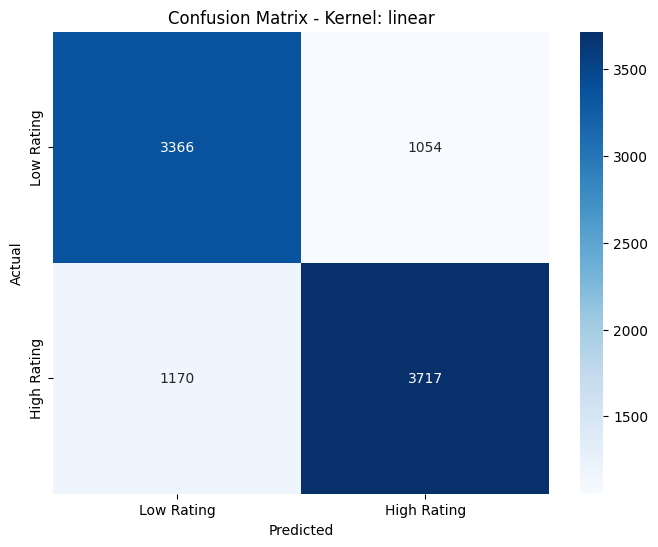

Kernel: rbf, Accuracy: 0.7729
Kernel: rbf, Precision: 0.7887
Kernel: rbf, Recall: 0.7751


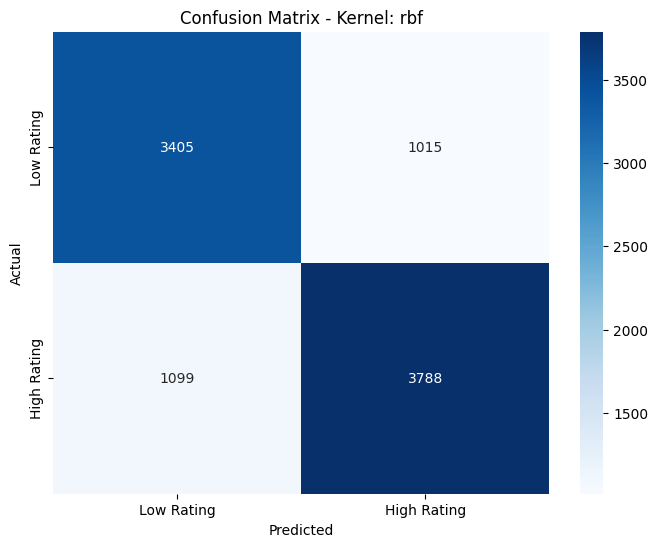

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

def plot_conf_mat(conf_matrix, title):

    labels = ['Low Rating', 'High Rating']

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


def evaluate_models(trained_models, X_test_norm, y_test):
    for kernel_name, clf in trained_models.items():
        y_pred = clf.predict(X_test_norm)
        accuracy = accuracy_score(y_test, y_pred)   
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"Kernel: {kernel_name}, Accuracy: {accuracy:.4f}")
        print(f"Kernel: {kernel_name}, Precision: {precision:.4f}")
        print(f"Kernel: {kernel_name}, Recall: {recall:.4f}")
        plot_conf_mat(conf_matrix, title=f'Confusion Matrix - Kernel: {kernel_name}')

evaluate_models(trained_models, X_test_norm, y_test)

Looking at the performance metrix we can see that there is a small difference between the kernel choices. Referring to the PP about SVM, we can see that the best method is to use SVC with RBF when there is few features and medium number of rows. 